<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/final_consolidated_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-Up

## Mount Drive

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Needed Libraries

In [36]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

## Define Needed Formulas

In [37]:
# Adjusted R Squared

def adjusted_r_squared(r_squared, n, k):
    return 1 - ((1 - r_squared) * ((n - 1) / (n - k - 1)))

# Data Cleaning & Merging

## Broad General Collateral Rate (BGCR) Data

In [38]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1. BGCR; SOFR/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Data

In [39]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

## Daily Treasury Rates LT Data

In [40]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

## Feature Additions

In [41]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

## Columns to Keep

In [42]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

## Add CPI

In [43]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)
cpi_long_df = cpi_long_df.resample('D').ffill()
cpi_long_df.reset_index(inplace=True)
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')

## Add SPX

In [44]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## Add NASDAQ

In [45]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

## Add DJIA

In [46]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

<ipython-input-46-884830d5858d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Add ForEx

In [47]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged6 = pd.merge(df_merged5, df, on='Date', how='inner')

# Model 1: ARIMAX With Initial Features

## Initial Feature Set

In [48]:
df_current = df_merged6.copy()
df_current = df_current.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_current.set_index('Date', inplace=True)
df_current2 = df_current.sort_index(ascending=True)
df_current2

# Replace 'ND' with NaN and fill with a method or drop rows
df_current2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_current2.isna().sum())

# Drop rows with NaN values in the dataframe
df_current2.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_current2[cols] = df_current2[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_current2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Training

In [49]:
# Split into train and test

train = df_current2[:'2022-12-31']
test = df_current2['2023-01-01':]

# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model_v1 = SARIMAX(y_train, exog= X_train_scaled, order= (1,1,1), seasonal_order= (0,0,0,0)) # order was (1,1,1) seasonal_order was (0,0,0,0)
model_v1_fit = model_v1.fit(disp=False)
print(model_v1_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               Rate (%)   No. Observations:                 1181
Model:               SARIMAX(1, 1, 1)   Log Likelihood            -6906784.849
Date:                Thu, 15 Aug 2024   AIC                       13813611.699
Time:                        00:48:10   BIC                       13813718.237
Sample:                             0   HQIC                      13813651.864
                               - 1181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1672   1.62e-05   1.03e+04      0.000       0.167       0.167
x2           3.93e+13   5.79e-06   6.79e+18      0.000    3.93e+13    3.93e+13
x3         -4.061e+13   5.45e-06  -7.46e+18      0.0

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


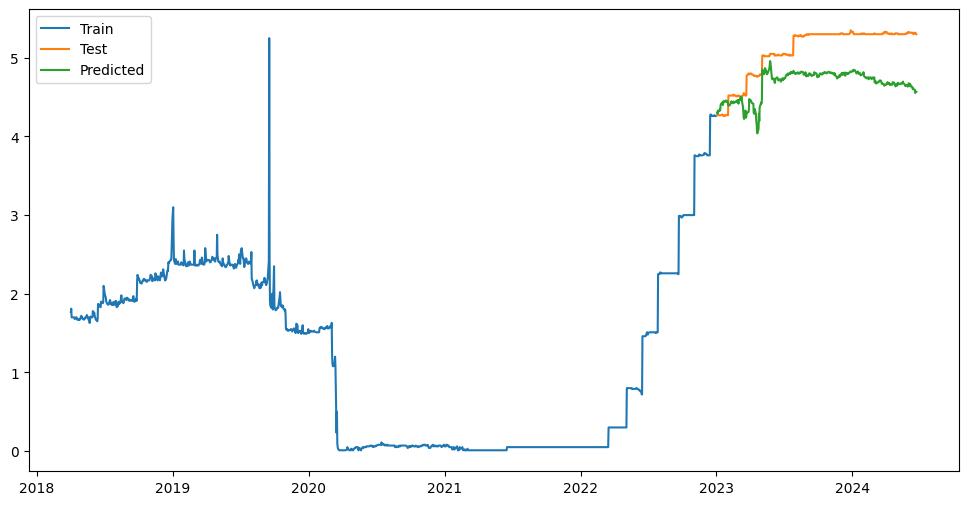

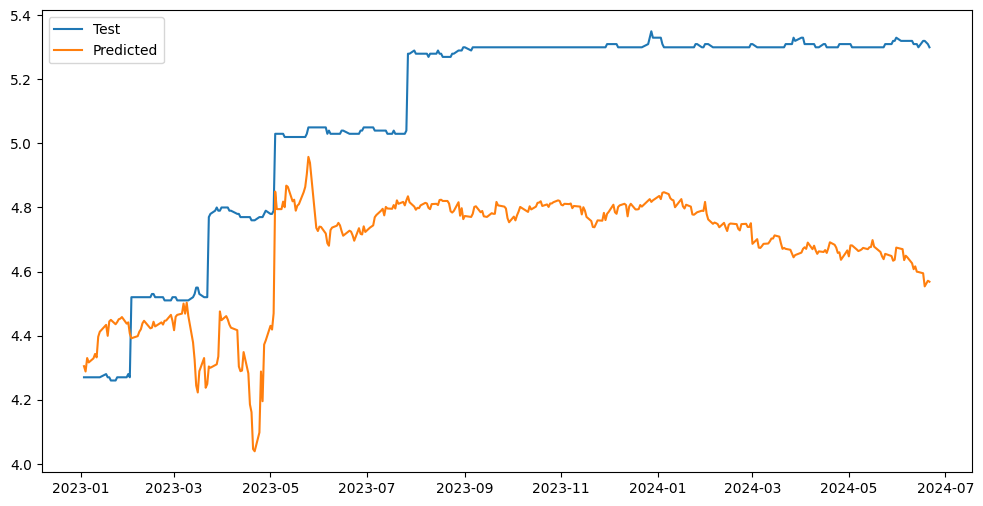

Mean Squared Error: 0.2245
Mean Absolute Error: 0.4356
R2 Score: -1.1521
Root Mean Squared Error: 0.4738
Adjusted R-squared: -1.2634


In [50]:
# Predict using the test set
y_pred = model_v1_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
n = len(y_test) # number of rows/observations
k = len(X_test_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 2: ARIMAX With Additional Features

## Add PPI

In [51]:
ppi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [114.8, 117, 119.3, 121.2, 133.576, 141.286, 142.683],
    'Feb': [115.1, 117.2, 118.6, 122, 134.821, 141.237, 143.509],
    'Mar': [115.3, 117.6, 118, 122.8, 137.041, 140.738, 143.410],
    'Apr': [115.5, 118.2, 116.6, 124.1, 137.805, 140.977, 144.119],
    'May': [115.9, 118.3, 117.2, 125.3, 139.026, 140.664, 144.079],
    'Jun': [116.3, 118.2, 117.5, 126.2, 140.238, 140.672, 144.402],
    'Jul': [116.4, 118.5, 118.2, 127.504, 139.837, 141.461, None],
    'Aug': [116.5, 118.6, 118.4, 128.574, 139.721, 142.353, None],
    'Sep': [116.7, 118.3, 118.7, 129.188, 140.137, 142.658, None],
    'Oct': [117.5, 118.8, 119.4, 130.061, 140.666, 142.191, None],
    'Nov': [117.4, 118.6, 119.5, 131.455, 141.18, 142.267, None],
    'Dec': [117.4, 119, 120, 132.224, 140.696, 142.17, None]
}

# Converting PPI data to DataFrame
ppi_df = pd.DataFrame(ppi_data)

# Melting the PPI DataFrame to long format
ppi_long_df = pd.melt(ppi_df, id_vars=['Year'], var_name='Month', value_name='PPI')

# Mapping month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
ppi_long_df['Month'] = ppi_long_df['Month'].map(month_mapping)

# Creating a 'Day' column with value 1 for each row
ppi_long_df['Day'] = 1

# Creating a date column in the PPI DataFrame
ppi_long_df['Date'] = pd.to_datetime(ppi_long_df[['Year', 'Month', 'Day']])

# Dropping unnecessary columns
ppi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
ppi_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known PPI value of each month
ppi_long_df = ppi_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
ppi_long_df.reset_index(inplace=True)

ppi_long_df['Date'] = pd.to_datetime(ppi_long_df['Date'])
df_merged7 = pd.merge(df_merged6, ppi_long_df[['Date', 'PPI']], on='Date', how='inner')

## Add Unemployment

In [52]:
unemp_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [4, 4, 3.6, 6.4, 4, 3.4, 3.7],
    'Feb': [4.1, 3.8, 3.5, 6.2, 3.8, 3.6, 3.9],
    'Mar': [4, 3.8, 4.4, 6.1, 3.6, 3.5, 3.8],
    'Apr': [4, 3.7, 14.8, 6.1, 3.7, 3.4, 3.9],
    'May': [3.8, 3.6, 13.2, 5.8, 3.6, 3.7, 4],
    'Jun': [4, 3.6, 11, 5.9, 3.6, 3.6, 4.1],
    'Jul': [3.8, 3.7, 10.2, 5.4, 3.5, 3.5, None],
    'Aug': [3.8, 3.6, 8.4, 5.1, 3.6, 3.8, None],
    'Sep': [3.7, 3.5, 7.8, 4.7, 3.5, 3.8, None],
    'Oct': [3.8, 3.6, 6.8, 4.5, 3.6, 3.8, None],
    'Nov': [3.8, 3.6, 6.7, 4.1, 3.6, 3.7, None],
    'Dec': [3.9, 3.6, 6.7, 3.9, 3.5, 3.7, None]
}

# Converting Unempl data to DataFrame
unemp_df = pd.DataFrame(unemp_data)

# Melting the Unempl DataFrame to long format
unemp_long_df = pd.melt(unemp_df, id_vars=['Year'], var_name='Month', value_name='Unemployment')

# Maunempng month names to numbers
month_maunempng = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
unemp_long_df['Month'] = unemp_long_df['Month'].map(month_maunempng)

# Creating a 'Day' column with value 1 for each row
unemp_long_df['Day'] = 1

# Creating a date column in the Unempl DataFrame
unemp_long_df['Date'] = pd.to_datetime(unemp_long_df[['Year', 'Month', 'Day']])

# Drounempng unnecessary columns
unemp_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
unemp_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known Unempl value of each month
unemp_long_df = unemp_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
unemp_long_df.reset_index(inplace=True)

unemp_long_df['Date'] = pd.to_datetime(unemp_long_df['Date'])
df_merged8 = pd.merge(df_merged7, unemp_long_df[['Date', 'Unemployment']], on='Date', how='inner')

## V2 Feature Set

In [53]:
df_model_v2 = df_merged8.copy()
df_model_v2 = df_model_v2.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v2.set_index('Date', inplace=True)
df_model_v2 = df_model_v2.sort_index(ascending=True)
df_model_v2

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v2.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v2.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v2.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v2[cols] = df_model_v2[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v2.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Training

In [54]:
# Split into train and test

train = df_model_v2[:'2022-12-31']
test = df_model_v2['2023-01-01':]

# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model_v2 = SARIMAX(y_train, exog= X_train_scaled, order= (1,1,1), seasonal_order= (0,0,0,0)) # order was (1,1,1) seasonal_order was (0,0,0,0)
model_v2_fit = model_v2.fit(disp=False)
print(model_v2_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               Rate (%)   No. Observations:                 1181
Model:               SARIMAX(1, 1, 1)   Log Likelihood           -12781182.832
Date:                Thu, 15 Aug 2024   AIC                       25562411.665
Time:                        00:48:23   BIC                       25562528.350
Sample:                             0   HQIC                      25562455.656
                               - 1181                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1751   4.07e-05   4303.335      0.000       0.175       0.175
x2          3.783e+13   9.64e-06   3.92e+18      0.000    3.78e+13    3.78e+13
x3         -3.909e+13   8.73e-06  -4.48e+18      0.0

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


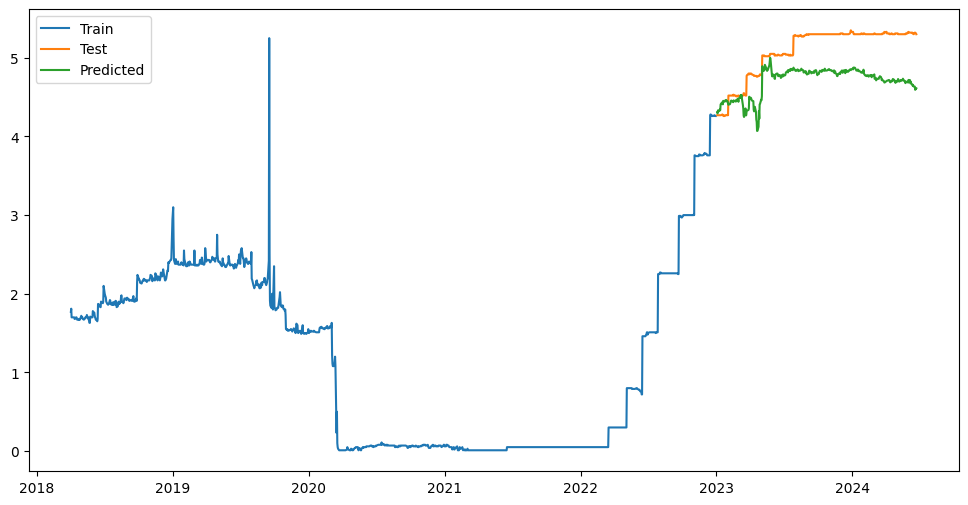

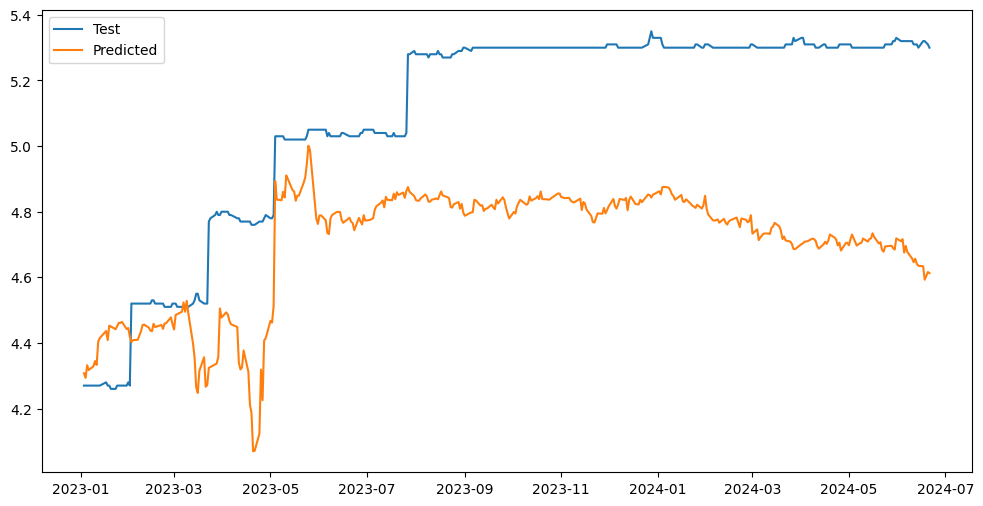

Mean Squared Error: 0.1956
Mean Absolute Error: 0.4038
R2 Score: -0.8758
Root Mean Squared Error: 0.4423
Adjusted R-squared: -0.9842


In [55]:
# Predict using the test set
y_pred = model_v2_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
n = len(y_test) # number of rows/observations
k = len(X_test_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 3: SARIMAX Model

## Re-introducing V2 Feature Set as V3

In [56]:
df_model_v3 = df_merged8.copy()
df_model_v3 = df_model_v3.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

# Set the 'Date' column as the index
df_model_v3.set_index('Date', inplace=True)
df_model_v3 = df_model_v3.sort_index(ascending=True)
df_model_v3

# Replace 'ND' with NaN and fill with a method or drop rows
df_model_v3.replace('ND', np.nan, inplace=True)

print("NaN values in original features dataframe before dropping:")
print(df_model_v3.isna().sum())

# Drop rows with NaN values in the dataframe
df_model_v3.dropna(inplace=True)

cols = ['SPOT EXCHANGE RATE - EURO AREA ', 'UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)', 'CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ', 'JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ']
df_model_v3[cols] = df_model_v3[cols].astype(float)

# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_model_v3.isna().sum())

NaN values in original features dataframe before dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
TREASURY 20-Yr CMT                                                0
Yield Spread (4W - 52W)                                           0
Yield Spread (13W - 52W)                                          0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (20Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
Yield Spread (20Y - 52W)                                          0
CPI                                                               0
SPX                                                               0
NASDAQ                                                   

## Checking for Seasonality

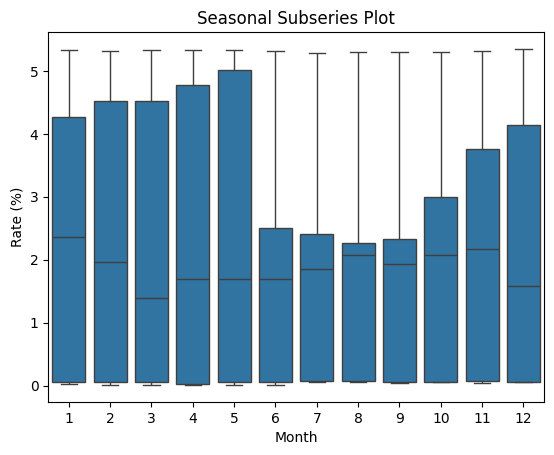

In [57]:
df_seasons= df_model_v3.copy()

df_seasons['Month'] = df_seasons.index.month
sns.boxplot(x='Month', y='Rate (%)', data=df_seasons.reset_index())
plt.title('Seasonal Subseries Plot')
plt.xlabel('Month')
plt.ylabel('Rate (%)')
plt.show()

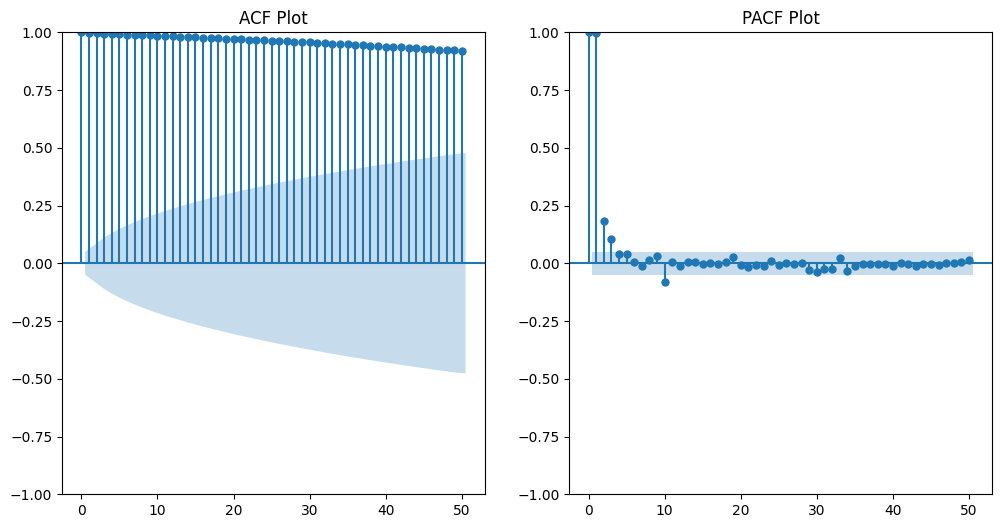

In [58]:
# Autocorrelation Function (ACF) Plot

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_seasons['Rate (%)'], lags=50, ax=plt.gca())
plt.title('ACF Plot')

#  Partial Autocorrelation Function (PACF)

plt.subplot(1, 2, 2)
plot_pacf(df_seasons['Rate (%)'], lags=50, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

In [59]:
# Ljung-Box Test

from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(df_seasons['Rate (%)'], lags=[12], return_df=True)
print(lb_test)

         lb_stat  lb_pvalue
12  18284.584561        0.0


## Training

In [33]:
# Split into train and test

train = df_model_v3[:'2022-12-31']
test = df_model_v3['2023-01-01':]

# Split into X & y

y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

# Scaling values

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# model definition

model_v2 = SARIMAX(y_train, exog= X_train_scaled, order= (0,1,0), seasonal_order= (1,1,2,6))
model_v2_fit = model_v2.fit(disp=False)
print(model_v2_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                               Rate (%)   No. Observations:                 1181
Model:             SARIMAX(0, 1, 0)x(1, 1, [1, 2], 6)   Log Likelihood                 666.024
Date:                                Wed, 14 Aug 2024   AIC                          -1284.048
Time:                                        22:38:14   BIC                          -1162.412
Sample:                                             0   HQIC                         -1238.179
                                               - 1181                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1653      0.163      1.016      0.309      -0.153       0.484
x2 

## Testing

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


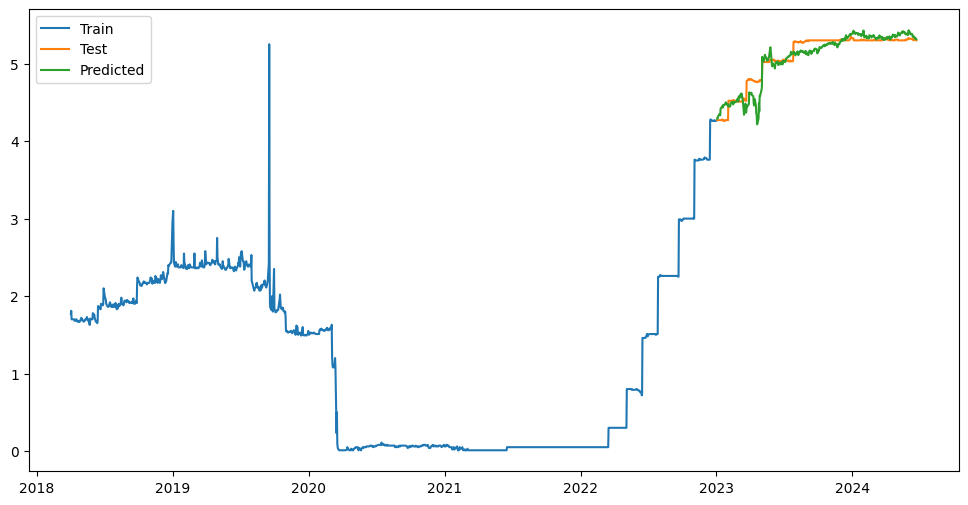

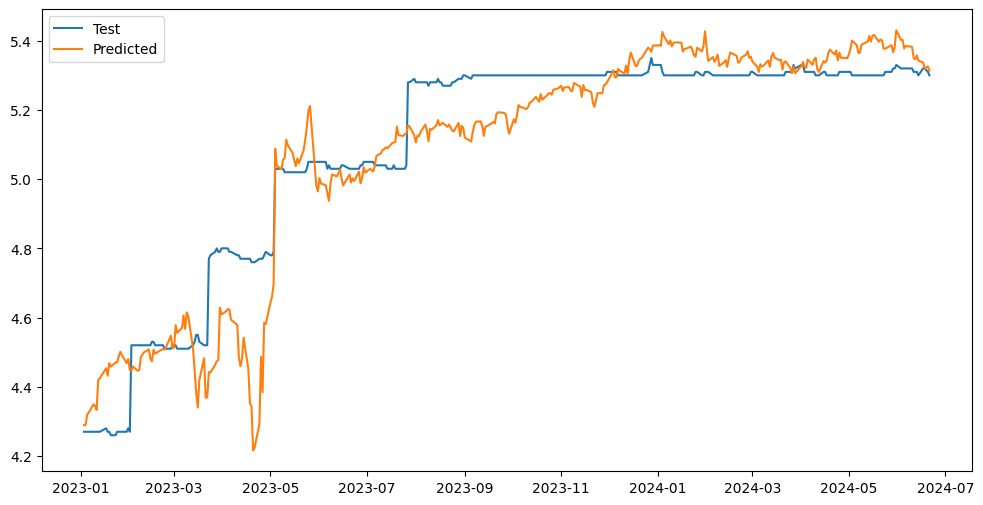

Mean Squared Error: 0.0144
Mean Absolute Error: 0.0881
R2 Score: 0.8624
Root Mean Squared Error: 0.1198
Adjusted R-squared: 0.8544


In [34]:
# Predict using the test set
y_pred = model_v2_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test_scaled)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

print("\n\n")

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rsquare = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
n = len(y_test) # number of rows/observations
k = len(X_test_scaled[0]) # number of independent variables/features
arsquare = adjusted_r_squared(rsquare, n, k)

# Print the evaluation metrics
print(f'Mean Squared Error: {round(mse,4)}')
print(f'Mean Absolute Error: {round(mae,4)}')
print(f'R2 Score: {round(rsquare,4)}')
print(f'Root Mean Squared Error: {round(rmse,4)}')
print(f'Adjusted R-squared: {round(arsquare,4)}')

# Model 4: SARIMAX Model with Lag and Difference Features

# Model 5: SARIMAX Model with Feature Selection

# Model 6: SARIMAX Model with Additional Features